### SVM Classifier with Feature Comparison

In [1]:
import json

import chardet
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy
import seaborn as sns
import sys
import warnings

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import stats

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [2]:
# Load data
data = pd.read_csv('processed_data/combined.csv')
data.head()

,subject_id,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,gender,age,diagnosis,adhd_binary,site_name
0,sub-0023001,5309.7,434.0,12642.4,65841.3,8371.4,4888.4,6444.8,1853.9,683.8,...,1498.0,3142.0,1226.0,8238.0,1270732.0,0.0,9.33,Control,NaN,OHSU
1,sub-0010011,4813.7,785.8,9892.7,45860.8,6487.5,3429.7,5657.9,1606.1,705.3,...,1626.0,2100.0,875.0,5565.0,992979.0,1.0,9.16,ADHD,NaN,NYU
2,sub-2427434,4891.9,423.1,11186.9,55092.0,7097.7,4590.8,6129.0,1644.6,509.2,...,1767.0,2944.0,1245.0,7786.0,1089479.0,1.0,8.08,Control,NaN,OHSU
3,sub-2230510,2535.1,543.5,12772.8,56887.6,6487.1,3495.2,5464.6,1604.3,529.8,...,1634.0,1771.0,968.0,5007.0,970763.0,0.0,9.17,ADHD,NaN,NYU
4,sub-0023006,4477.6,378.9,11991.9,62007.1,6189.8,3987.9,5120.0,1498.6,537.6,...,1231.0,2496.0,1124.0,7411.0,1045207.0,1.0,9.25,Control,NaN,OHSU


In [3]:
# Update adhd_binary column based on diagnosis
data['adhd_binary'] = data['diagnosis'].apply(lambda x: 1 if x == 'ADHD' else 0)

In [4]:
# Check for NaN values
print("NaN count in each column:")
nan_counts = data.isna().sum()
print(nan_counts[nan_counts > 0])

NaN count in each column:
eTIV    434
dtype: int64


In [5]:
# Clean data by removing non-feature columns and columns with NaN values
columns_with_nans = nan_counts[nan_counts > 0].index.tolist()
fields_to_drop = ['subject_id', 'gender', 'age', 'diagnosis', 'site_name'] + columns_with_nans
clean_data = data.drop(columns=fields_to_drop)

# Get all available features (excluding the target variable)
all_features = [col for col in clean_data.columns if col != 'adhd_binary']
print(f"\nTotal available features: {len(all_features)}")

# Prepare target variable
y = clean_data['adhd_binary']

# Print dataset information
print(f"\nDataset Information:")
print(f"Total number of samples: {len(clean_data)}")
print(f"Number of ADHD samples (class 1): {sum(y == 1)}")
print(f"Number of control samples (class 0): {sum(y == 0)}")
print(f"Class proportion (ADHD/Total): {sum(y == 1)/len(y):.3f}")


Total available features: 279

Dataset Information:
Total number of samples: 434
Number of ADHD samples (class 1): 187
Number of control samples (class 0): 247
Class proportion (ADHD/Total): 0.431


In [6]:
# Alternative: Use stratified sampling from sklearn (simpler approach)
def create_stratified_subsets(X, y, sample_sizes):
    """Alternative approach using sklearn's train_test_split for stratified sampling"""
    from sklearn.model_selection import train_test_split

    subsets_sklearn = {}

    for size in sample_sizes:
        if size >= len(y):
            print(f"Warning: Sample size {size} >= total samples {len(y)}")
            continue

        # Calculate test size as proportion
        test_size = size / len(y)

        # Use stratified sampling
        _, X_subset, _, y_subset = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        subsets_sklearn[f'{size}_samples'] = {
            'data': X_subset,
            'target': y_subset,
            'n_adhd': sum(y_subset == 1),
            'n_control': sum(y_subset == 0),
            'actual_proportion_adhd': sum(y_subset == 1) / len(y_subset)
        }

        print(f"\nStratified subset with {len(y_subset)} samples:")
        print(f"  ADHD samples: {sum(y_subset == 1)}")
        print(f"  Control samples: {sum(y_subset == 0)}")
        print(f"  ADHD proportion: {sum(y_subset == 1) / len(y_subset):.3f}")

    return subsets_sklearn

In [7]:
def evaluate_svm(X, y, feature_names, description):
    """Train and evaluate SVM with given features"""
    print(f"\n{'='*60}")
    print(f"Evaluating: {description}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Features: {list(feature_names)[:10]}{'...' if len(feature_names) > 10 else ''}")
    print(f"{'='*60}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train SVM
    svm = SVC(kernel='rbf', probability=True, random_state=42)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=cv, scoring='accuracy')

    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Train on full training set and make predictions
    svm.fit(X_train_scaled, y_train)
    y_pred = svm.predict(X_test_scaled)
    y_pred_prob = svm.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_prob),
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    # Print metrics
    print(f"\nTest Set Performance:")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"AUC:       {metrics['auc']:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"              Predicted")
    print(f"           Control  ADHD")
    print(f"Actual Control  {cm[0,0]:3d}   {cm[0,1]:3d}")
    print(f"       ADHD     {cm[1,0]:3d}   {cm[1,1]:3d}")

    return metrics, (y_test, y_pred_prob), svm, scaler

In [8]:
# Prepare data for different feature sets
top_20 = [
    'lh_precuneus_thickness',
    'rh_middletemporal_thickness',
    'lh_transversetemporal_thickness',
    'rh_frontalpole_thickness',
    'lh_transversetemporal_volume',
    'rh_precuneus_thickness',
    'SurfaceHoles',
    'rh_fusiform_volume',
    'lh_bankssts_volume',
    'rh_medialorbitofrontal_area',
    'rh_cuneus_volume',
    'lh_MeanThickness_thickness',
    'rh_precuneus_volume',
    'lh_inferiortemporal_thickness',
    'lh_middletemporal_thickness',
    'lh_inferiortemporal_volume',
    'lh_entorhinal_area',
    'lh_rostralanteriorcingulate_area',
    'rh_MeanThickness_thickness',
    'lhSurfaceHoles',
]
top_10 = top_20[:10]

dataset = {
    'all_features': all_features,
    'top_10': top_10,
    'top_20': top_20,
}

# Dictionary to store results
results = {}
roc_data = {}

In [9]:
import json
print(json.dumps(dataset, indent=4))

{
    "all_features": [
        "Left-Lateral-Ventricle",
        "Left-Inf-Lat-Vent",
        "Left-Cerebellum-White-Matter",
        "Left-Cerebellum-Cortex",
        "Left-Thalamus",
        "Left-Caudate",
        "Left-Putamen",
        "Left-Pallidum",
        "3rd-Ventricle",
        "4th-Ventricle",
        "Brain-Stem",
        "Left-Hippocampus",
        "Left-Amygdala",
        "CSF",
        "Left-Accumbens-area",
        "Left-VentralDC",
        "Left-vessel",
        "Left-choroid-plexus",
        "Right-Lateral-Ventricle",
        "Right-Inf-Lat-Vent",
        "Right-Cerebellum-White-Matter",
        "Right-Cerebellum-Cortex",
        "Right-Thalamus",
        "Right-Caudate",
        "Right-Putamen",
        "Right-Pallidum",
        "Right-Hippocampus",
        "Right-Amygdala",
        "Right-Accumbens-area",
        "Right-VentralDC",
        "Right-vessel",
        "Right-choroid-plexus",
        "5th-Ventricle",
        "WM-hypointensities",
        "Left-WM-hypoi

In [10]:
results = {}
roc_data = {}
for key, value in dataset.items():
    print(f'\nStart analysis for {key}')
    metrics, roc, model, scaler = evaluate_svm(
        clean_data[value],
        y,
        value,
        key
    )
    results[key] = metrics
    roc_data[key] = roc



Start analysis for all_features

Evaluating: all_features
Number of features: 279
Features: ['Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle', '4th-Ventricle']...
Cross-validation accuracy: 0.6798 ± 0.0425

Test Set Performance:
Accuracy:  0.7405
Precision: 0.7750
Recall:    0.5536
F1 Score:  0.6458
AUC:       0.8431

Confusion Matrix:
              Predicted
           Control  ADHD
Actual Control   66     9
       ADHD      25    31

Start analysis for top_10

Evaluating: top_10
Number of features: 10
Features: ['lh_precuneus_thickness', 'rh_middletemporal_thickness', 'lh_transversetemporal_thickness', 'rh_frontalpole_thickness', 'lh_transversetemporal_volume', 'rh_precuneus_thickness', 'SurfaceHoles', 'rh_fusiform_volume', 'lh_bankssts_volume', 'rh_medialorbitofrontal_area']
Cross-validation accuracy: 0.6634 ± 0.0211

Test Set Performance:
Accura

In [11]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print(f"\n{'='*80}")
print("PERFORMANCE COMPARISON SUMMARY")
print(f"{'='*80}")
print(comparison_df)


PERFORMANCE COMPARISON SUMMARY
              accuracy  precision  recall      f1     auc  cv_mean  cv_std
all_features    0.7405     0.7750  0.5536  0.6458  0.8431   0.6798  0.0425
top_10          0.7481     0.7347  0.6429  0.6857  0.7521   0.6634  0.0211
top_20          0.7405     0.7292  0.6250  0.6731  0.8007   0.6898  0.0208


In [12]:
# Find best performing configuration for each metric
print(f"\nBest Performance by Metric:")
print(f"{'='*40}")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    best_config = comparison_df[metric].idxmax()
    best_score = comparison_df.loc[best_config, metric]
    print(f"{metric.capitalize():10}: {best_config:15} ({best_score:.4f})")


Best Performance by Metric:
Accuracy  : top_10          (0.7481)
Precision : all_features    (0.7750)
Recall    : top_10          (0.6429)
F1        : top_10          (0.6857)
Auc       : all_features    (0.8431)


In [16]:
def create_confusion_matrix_heatmap(y_true, y_pred, title, fig=None, ax=None, save_individual=False, save_path=None):
    """Create a styled confusion matrix heatmap similar to the provided image"""
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
        standalone = True
    else:
        standalone = False

    # Create heatmap with custom styling
    im = ax.imshow(cm, interpolation='nearest', cmap='RdYlBu_r')

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=16, fontweight='bold')

    # Customize the plot
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel('Predicted class', fontsize=12, fontweight='bold')
    ax.set_xlabel('Actual class', fontsize=12, fontweight='bold')

    # Set tick labels
    class_names = ['TDC', 'ADHD']  # TDC = Typically Developing Controls
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names, fontsize=11)
    ax.set_yticklabels(class_names, fontsize=11)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Count', rotation=270, labelpad=15, fontweight='bold')

    # Save individual figure if requested
    if save_individual and standalone:
        if save_path is None:
            # Create a safe filename from title
            safe_title = title.lower().replace(' ', '_').replace('/', '_')
            save_path = f'results/confusion_matrix_{safe_title}.png'

        # Create results directory if it doesn't exist
        import os
        os.makedirs('results', exist_ok=True)

        fig.savefig(save_path, dpi=300, format='png', bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        print(f"Individual figure saved to: {save_path}")

    return ax


Combined confusion matrices saved to: results/confusion_matrices_combined.png


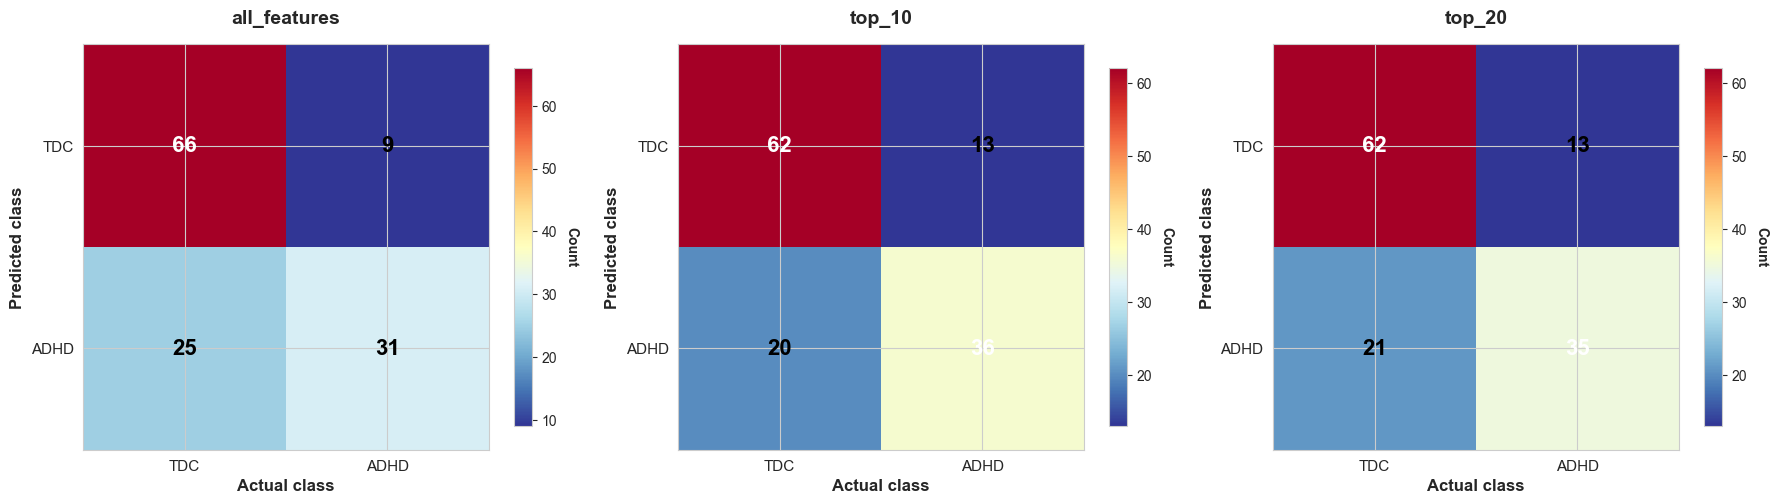

In [18]:
# Store confusion matrices for each model
confusion_matrices = {}

for key, value in dataset.items():
    X_all = clean_data[value]
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train_scaled, y_train)
    y_pred_all = svm.predict(X_test_scaled)
    confusion_matrices[key] = (y_test, y_pred_all)

# Option 1: Save combined figure with all three confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

titles = ['All Features', 'Top 10 Features', 'Top 20 Features']
for i, (title, (y_true, y_pred)) in enumerate(confusion_matrices.items()):
    print(y_pred)
    print(y_true)
    create_confusion_matrix_heatmap(y_true, y_pred, title, fig=fig, ax=axes[i])

plt.tight_layout()
# Save the combined figure
plt.savefig('/Users/stevenang/DataspellProjects/DataProcessing/results/confusion_matrices_combined.png', dpi=300, format='png',
            bbox_inches='tight', facecolor='white', edgecolor='none')
print("Combined confusion matrices saved to: results/confusion_matrices_combined.png")
plt.show()

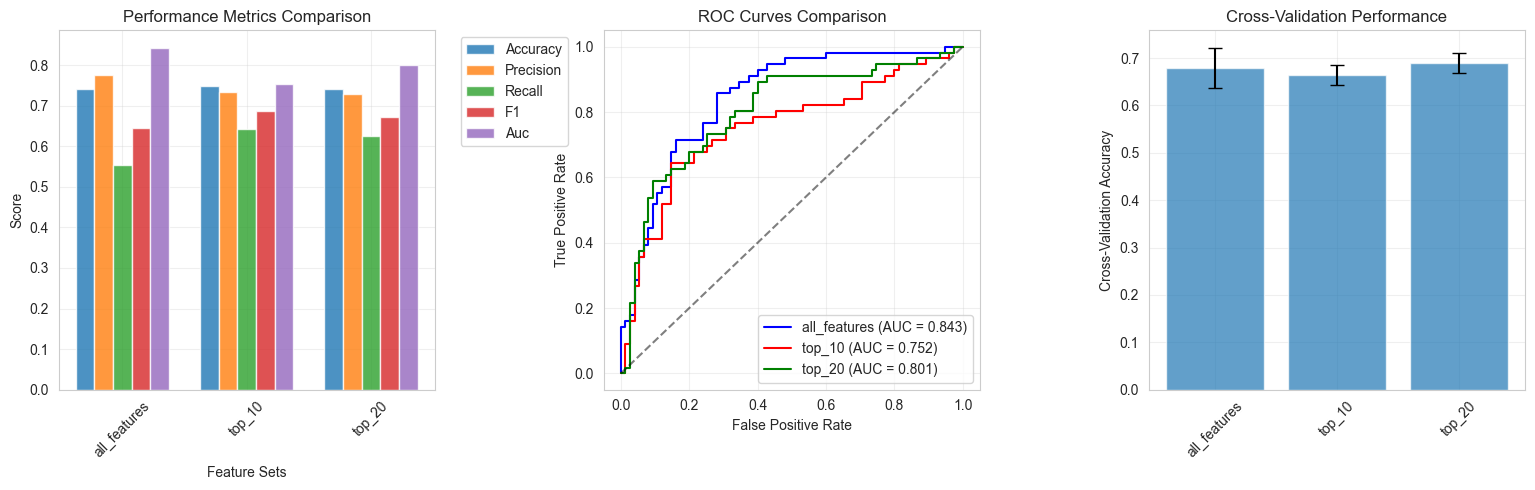

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 1. Performance metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
x_pos = np.arange(len(comparison_df.index))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    ax1.bar(x_pos + i*width, comparison_df[metric], width,
            label=metric.capitalize(), alpha=0.8)

ax1.set_xlabel('Feature Sets')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics Comparison')
ax1.set_xticks(x_pos + width*2)
ax1.set_xticklabels(comparison_df.index, rotation=45)
# Position legend outside the plot area
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. ROC curves
colors = ['blue', 'red', 'green']
for i, (name, (y_test, y_pred_prob)) in enumerate(roc_data.items()):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = results[name]['auc']
    ax2.plot(fpr, tpr, color=colors[i], label=f'{name} (AUC = {auc_score:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison')
# Position legend in bottom right (good for ROC curves)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# 3. Cross-validation scores
cv_means = [results[name]['cv_mean'] for name in comparison_df.index]
cv_stds = [results[name]['cv_std'] for name in comparison_df.index]

ax3.bar(comparison_df.index, cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
ax3.set_ylabel('Cross-Validation Accuracy')
ax3.set_title('Cross-Validation Performance')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

plt.savefig('/Users/stevenang/DataspellProjects/DataProcessing/results/performance.png', dpi=300, format='png',
            bbox_inches='tight', facecolor='white', edgecolor='none')

# Adjust layout to accommodate the external legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the external legend
plt.show()